<a href="https://colab.research.google.com/github/hamagami/anomaly-detection/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAEによる画像の異常検知 
original code from https://github.com/tarekmuallim/Anomaly-Detection-using-Variational-Autoencoders/blob/master/anomaly_detection_using_vae.py　このコードに手を加えて解説をつけている

AEにくらべVAEは潜在変数を学習するため，未知のデータに対して誤りをすくなるすることができるといわれています。ここではMNISTを例に画像の異常検知を確認します。

In [ ]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]    
    epsilon = K.random_normal(shape=(batch, dim))  # by default, random_normal has mean=0 and std=1.0
    return z_mean + K.exp(0.5* z_log_var) * epsilon

## MNISTデータ取得

## 手書き文字１のデータを学習データとして用意し，学習用に正規化する

(60000, 28, 28)
(60000,)
(6742, 28, 28)
(1135, 28, 28)


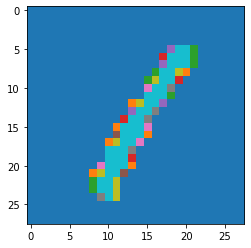

In [ ]:
 # MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# get data for one digit "1"

print(x_train.shape)
print(y_train.shape)

dig_class = 1

indexes = []
for i, j in enumerate(y_train):
    if j == dig_class:
        indexes.append(i)
        

x_train_t = x_train[indexes]

#1のみとりだす
indexes = []
for i, j in enumerate(y_test):
    if j == dig_class:
        indexes.append(i)


x_test_t = x_test[indexes]

x_train = x_train_t
x_test = x_test_t
print(x_train.shape)
print(x_test.shape)
plt.imshow(x_train[0])

# reshape and normalization
# 各画像を1次配列にして，学習とテスト用にわける
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


###　VAEネットワークの設計

In [ ]:
# network parameters and learning parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# sampling 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

# VAE loss
# reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae_loss = K.mean(reconstruction_loss)

# vae.compile(optimizer='adam', loss=vae_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_12[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_12[0][0]                   
____________________________________________________________________________________________

## 学習


Epoch 1/50
53/53 [==============================] - 1s 27ms/step - loss: 213.0519 - val_loss: 109.6953
Epoch 2/50
53/53 [==============================] - 1s 24ms/step - loss: 87.9736 - val_loss: 74.5296
Epoch 3/50
53/53 [==============================] - 1s 25ms/step - loss: 71.7159 - val_loss: 67.8056
Epoch 4/50
53/53 [==============================] - 1s 24ms/step - loss: 67.3321 - val_loss: 64.9167
Epoch 5/50
53/53 [==============================] - 1s 24ms/step - loss: 65.2206 - val_loss: 63.4205
Epoch 6/50
53/53 [==============================] - 1s 24ms/step - loss: 63.9840 - val_loss: 62.4417
Epoch 7/50
53/53 [==============================] - 1s 25ms/step - loss: 63.1059 - val_loss: 61.8574
Epoch 8/50
53/53 [==============================] - 1s 25ms/step - loss: 62.4698 - val_loss: 61.2235
Epoch 9/50
53/53 [==============================] - 1s 25ms/step - loss: 61.8058 - val_loss: 60.6235
Epoch 10/50
53/53 [==============================] - 1s 25ms/step - loss: 61.0932 - val_l

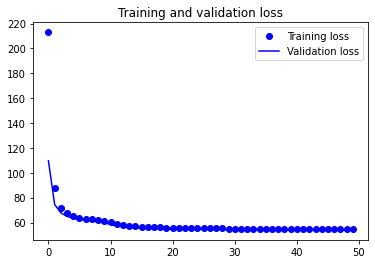

In [ ]:
# Learning
# epochs = 50
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

vae.save_weights('vae_mnist.h5')

# plot loss history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### テストデータをいれたときの潜在変数の分布を確認

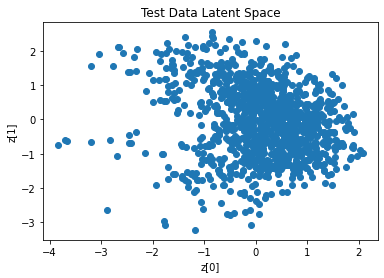

In [ ]:
# Visualization of latent space
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Test Data Latent Space')
plt.show()

### 学習データをいれたときの潜在変数を確認

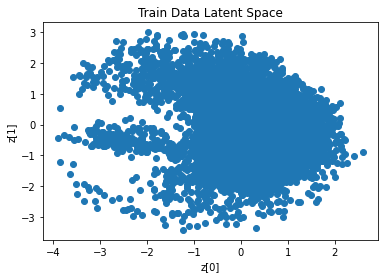

In [ ]:
# Visualization of latent space
z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Train Data Latent Space')
plt.show()

### 学習したVAEの潜在変数を適当に変えて，どのような出力がでてくるか確認。１で学習しているので，いろいろな１がでてくることになる。

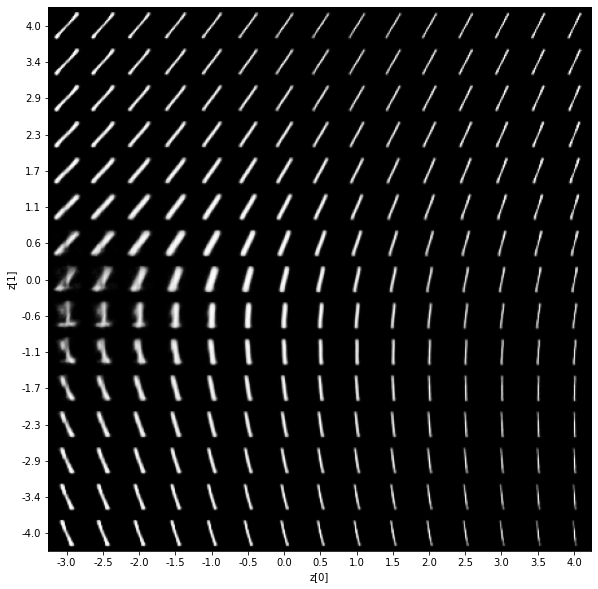

In [ ]:
# display a 30x30 2D manifold of digits
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='gray')
plt.show()

## 再度MNISTからデータを読みこみ，すべてを正規化

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### すべてのデータに対して，学習済VAEをいれて内部変数を確認

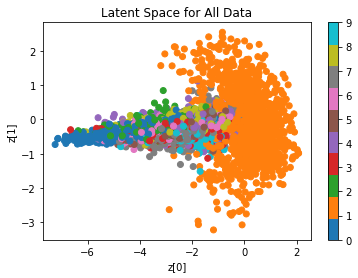

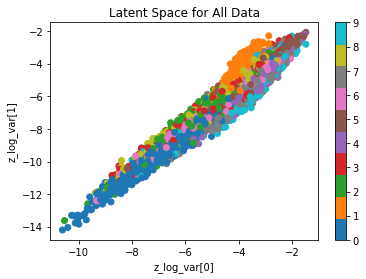

In [ ]:
"""# Visualization of Latent Space
When we supply the whole data to the trained VAE, we can see that result is separable
the anomaly digits (digits which is not "one") are outside the distribution of normal latent space.
"""

# Visualization of latent space
z_mean,z_log_var, _ = encoder.predict(x_test, batch_size=batch_size)

plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.set_cmap('tab10')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Latent Space for All Data')
plt.show()

# Visualization of latent space

plt.scatter(z_log_var[:, 0], z_log_var[:, 1], c=y_test)
plt.colorbar()
plt.set_cmap('tab10')
plt.xlabel("z_log_var[0]")
plt.ylabel("z_log_var[1]")
plt.title('Latent Space for All Data')
plt.show()

### 入力に対する復元画像を確認，１に対しては当然１がでてくるが，１でない入力についても，すべて１に近い画像がでてくるはず（復元誤差が大きい）

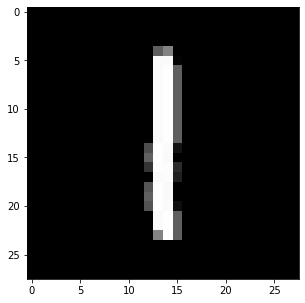

NotImplementedError: ignored

In [41]:
# test reconstruction for one digit

i = 14

digit_size = 28


digit = x_train[i].reshape(digit_size, digit_size)

figure = digit
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='gray')
plt.show()



z_sample = np.array(z_mean)
x_decoded = decoder.predict(z_sample)
digit = x_decoded[i].reshape(digit_size, digit_size)


figure = digit
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='gray')
plt.show()

# test reconstruction
n = 20
digit_size = 28
figure = np.zeros((digit_size * 2, digit_size * n))
grid_x = np.linspace(0, n, n)


for j, xi in enumerate(grid_x):
        z_sample = np.array(z_mean)
        x_decoded = decoder.predict(z_sample)
        digit = x_train[j].reshape(digit_size, digit_size)
        figure[0 * digit_size: (0 + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        digit = x_decoded[j].reshape(digit_size, digit_size)
        figure[1 * digit_size: (1 + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(n, n))
    
plt.imshow(figure, cmap='gray')
plt.show()
plt.show()